# 0.Import libraries and set up the base environment

In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device', device)

device cuda


In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')
# os.chdir("/content/drive/MyDrive/homework/work/")

# 1.Data preparing

For this image recognition project, I am going to use the FashionMNIST dataset. Fashion-MNIST is a dataset consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Since the downloaded train_data and test_data are dataset objects, we need to use the DataLoader in order to make a python iterable dataset from that dataset. I broke the data down into 32 images at a time (a batch size of 32). This not only makes the computation more efficient, but also gives our neural network more opportunities to update its gradients per epoch.

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Define a transform to Pre-processed the data
pipeline = transforms.Compose([transforms.ToTensor()])

# Download and load the data
train_data = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = pipeline)
test_data = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = pipeline)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [5]:
# View data details
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")
print(f"Train dataloader:\n{train_dataloader}\nTest dataloader:\n{test_dataloader}")

Train data:
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Test data:
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Train dataloader:
Test dataloader:


# 3.Visualising Images

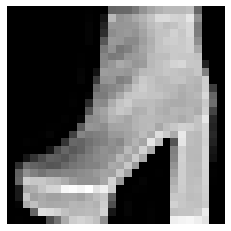

In [6]:
#Examine a sample
plt.axis("off")
plt.imshow(train_data[643][0].squeeze(0),cmap='gray' )

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

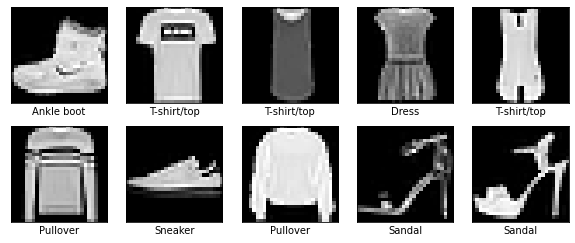

In [9]:
# Checking first 10 images in training data along with the labels
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i][0].squeeze(0),cmap='gray')
    plt.xlabel(class_names[train_data[i][1]])
plt.show()

# 4.Build the basic model(model_1)

When starting to build a series of machine learning modelling experiments, it is best practice to start with a baseline model. First I choose to use a small neural network for training. The baseline model is a simple one that I will try to improve with subsequent models.

### 4.1 Set up the model framework

A regular neural network takes input (a single vector) and transforms it through a series of hidden layers. Each hidden layer consists of a set of neurons, each of which is fully connected to all the neurons in the previous layer, and the neurons in a single layer operate completely independently and do not share any connections. The last fully connected layer is called the "output layer" and represents the category score in the classification setting.Here we use two linear layers, two activation layers and one fully connected layer.



In [10]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_feat : int, output_feat : int, hidden_units = 10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_feat, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_feat),
        nn.ReLU()
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)
   

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)


In [11]:
# View model details
model_1 = FashionMNISTModelV0(input_feat = 784, output_feat = len(class_names), hidden_units = 10).to(device) 
model_1

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [12]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


### 4.2 Set up the loss and optimizer

In model 1, we used stochastic gradient descent (SGD) as the optimiser and set the learning rate to 0.01. SGD approximates the average loss with the loss of a single training sample, i.e. the current gradient is estimated by sampling one sample at a time at random, and the model parameters are updated once.Its advantages are that it can converge very quickly when using mini-batch, while it has a fast training speed and low memory overhead.
However, it also has obvious disadvantages, such as the introduction of noise while selecting the gradient randomly, making the direction of the weight update not always correct. In addition, SGD receives limited information at each step and the accuracy of the gradient estimation is low, resulting in unstable convergence of the objective function with oscillations and even non-convergence. In other words, SGD is stochastic and does not guarantee global optimisation.


In [13]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

###4.3 Create a function to record our experiment


I print the training log of the model and for this I had to focus on two main points:
1. The performance of the model (loss and accuracy values, etc.).
2. How fast it runs.

In [14]:
from tqdm import tqdm
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn)
        
        #  Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        #  Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    #  Return the filled results at the end of the epochs
    return results

In [27]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

NUM_EPOCHS=5
model_1_results = train(model_1,train_dataloader,test_dataloader, optimizer,loss_fn,NUM_EPOCHS)


Total training time: 0.000 seconds


 20%|██        | 1/5 [00:10<00:41, 10.43s/it]

Epoch: 1 | train_loss_2: 2.3031 | train_acc_2: 0.1174 | test_loss_2: 2.3031 | test_acc_2: 0.1156


 40%|████      | 2/5 [00:20<00:29,  9.97s/it]

Epoch: 2 | train_loss_2: 2.3031 | train_acc_2: 0.1174 | test_loss_2: 2.3031 | test_acc_2: 0.1156


 60%|██████    | 3/5 [00:29<00:19,  9.78s/it]

Epoch: 3 | train_loss_2: 2.3031 | train_acc_2: 0.1174 | test_loss_2: 2.3031 | test_acc_2: 0.1156


 80%|████████  | 4/5 [00:39<00:09,  9.99s/it]

Epoch: 4 | train_loss_2: 2.3031 | train_acc_2: 0.1174 | test_loss_2: 2.3031 | test_acc_2: 0.1156


100%|██████████| 5/5 [00:49<00:00,  9.91s/it]

Epoch: 5 | train_loss_2: 2.3031 | train_acc_2: 0.1174 | test_loss_2: 2.3031 | test_acc_2: 0.1156


# 5.Building the CNN model(model_2)

Convolutional neural network (CNN) is a class of feedforward neural networks that include convolutional computation and have a deep structure. Convolutional neural networks are proposed by the biological mechanism of Receptive Field. Convolutional neural networks are specifically designed to process neural networks with data that have a grid-like structure. For example, time series data (which can be thought of as a one-dimensional grid formed by regular sampling on a time axis) and image data (which can be thought of as a two-dimensional grid of pixels).


### 5.1 Set up the model framework

Model 2 uses a convolutional neural network, borrowed from the Tiny 
VGG model architecture. The model consists of two sets of convolutions followed by a fully connected layer, each of which is of the same form (conv-relu-conv-relu-pool).The two main advantages of VGG are: deeper and wider layers and smaller convolution kernels. Because of the smaller convolution kernels, the use of smaller convolution kernels leads to a reduction in the number of parameters, allowing for a more steadily increasing number of layers without worrying too much about the computational overload.




In [15]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1), 
        nn.ReLU(),
        nn.Conv2d( in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3, 
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7, 
                  out_features = output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier_layer(x)
    return x


In [16]:
# View model details
model_2 = FashionMNISTModelV2(input_shape=1,hidden_units=10,output_shape=10).to(device)
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [17]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss_2, train_acc_2 = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss_2 += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc_2 += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss_2 = train_loss_2 / len(dataloader)
    train_acc_2 = train_acc_2 / len(dataloader)
    return train_loss_2, train_acc_2

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss_2, test_acc_2 = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss_2 += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc_2 += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss_2 = test_loss_2 / len(dataloader)
    test_acc_2 = test_acc_2 / len(dataloader)
    return test_loss_2, test_acc_2


###5.2 Set up the loss and optimizer

To optimise the shortcomings of the SGD algorithm, we use adaptive moment estimation (Adam) as an optimiser here.
The advantage of Adam is that, after bias correction, there is a defined range of learning rates for each iteration, making the parameters relatively smooth.

At the same time, we set an adaptive learning rate, i.e. set the learning rate to gradually decrease as the epoch increases, resulting in better training results. 

In [22]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

#Set up adaptive learning rate
def myfunction(epoch):
  if epoch <= 5:
    return 0.01
  elif epoch <=10:
    return 0.005
  else:
    return 0.001
LR = myfunction(epoch=5)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=LR)


###5.3 Create a function to record our experiment

In [23]:
from tqdm import tqdm
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # Create empty results dictionary
    results = {"train_loss_2": [],
        "train_acc_2": [],
        "test_loss_2": [],
        "test_acc_2": []
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn)
        
        #  Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss_2: {train_loss:.4f} | "
            f"train_acc_2: {train_acc:.4f} | "
            f"test_loss_2: {test_loss:.4f} | "
            f"test_acc_2: {test_acc:.4f}"
        )

        #  Update results dictionary
        results["train_loss_2"].append(train_loss)
        results["train_acc_2"].append(train_acc)
        results["test_loss_2"].append(test_loss)
        results["test_acc_2"].append(test_acc)

    #  Return the filled results at the end of the epochs
    return results

In [28]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

model_2_results = train(model_2,train_dataloader,test_dataloader, optimizer,loss_fn,5)


Total training time: 0.000 seconds


 20%|██        | 1/5 [00:11<00:47, 11.79s/it]

Epoch: 1 | train_loss_2: 0.2690 | train_acc_2: 0.9032 | test_loss_2: 0.3017 | test_acc_2: 0.8914


 40%|████      | 2/5 [00:23<00:35, 11.85s/it]

Epoch: 2 | train_loss_2: 0.2594 | train_acc_2: 0.9066 | test_loss_2: 0.3112 | test_acc_2: 0.8901


 60%|██████    | 3/5 [00:36<00:24, 12.45s/it]

Epoch: 3 | train_loss_2: 0.2579 | train_acc_2: 0.9066 | test_loss_2: 0.3006 | test_acc_2: 0.8928


 80%|████████  | 4/5 [00:48<00:12, 12.23s/it]

Epoch: 4 | train_loss_2: 0.2571 | train_acc_2: 0.9071 | test_loss_2: 0.2984 | test_acc_2: 0.8947


100%|██████████| 5/5 [01:00<00:00, 12.10s/it]

Epoch: 5 | train_loss_2: 0.2561 | train_acc_2: 0.9076 | test_loss_2: 0.3177 | test_acc_2: 0.8872


###5.4 Adjust training parameters, set to 20 epochs

One epoch is equivalent to training once using all the samples in the 
training set, so we increased the epoch from 5 to 20 to increase the number of passes of the data set through the same neural network. As the number of epochs increases, the number of updates to the weights in the neural network also increases, and the curve tends to overfit from underfitting. Therefore, increasing the number of epochs within a certain range can improve the accuracy of the training dataset, but over-increasing the epochs can over-fit the model, and choosing the right number of epochs is important for training.






In [29]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = FashionMNISTModelV2(1,10,10).to(device)

#Set up adaptive learning rate
def myfunction(epoch):
  if epoch <= 5:
    return 0.01
  elif epoch <=10:
    return 0.005
  else:
    return 0.001
LR = myfunction(epoch=50)

loss_fn=nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2.parameters(), lr=LR)

model_2_results = train(model_2,train_dataloader,test_dataloader, optimizer,loss_fn,20)

  5%|▌         | 1/20 [00:11<03:46, 11.95s/it]

Epoch: 1 | train_loss_2: 0.5431 | train_acc_2: 0.8032 | test_loss_2: 0.4058 | test_acc_2: 0.8528


 10%|█         | 2/20 [00:23<03:34, 11.92s/it]

Epoch: 2 | train_loss_2: 0.3592 | train_acc_2: 0.8706 | test_loss_2: 0.3528 | test_acc_2: 0.8727


 15%|█▌        | 3/20 [00:35<03:21, 11.87s/it]

Epoch: 3 | train_loss_2: 0.3244 | train_acc_2: 0.8829 | test_loss_2: 0.3465 | test_acc_2: 0.8734


 20%|██        | 4/20 [00:47<03:10, 11.88s/it]

Epoch: 4 | train_loss_2: 0.3008 | train_acc_2: 0.8913 | test_loss_2: 0.3262 | test_acc_2: 0.8828


 25%|██▌       | 5/20 [00:59<02:57, 11.85s/it]

Epoch: 5 | train_loss_2: 0.2860 | train_acc_2: 0.8961 | test_loss_2: 0.3179 | test_acc_2: 0.8876


 30%|███       | 6/20 [01:11<02:45, 11.86s/it]

Epoch: 6 | train_loss_2: 0.2724 | train_acc_2: 0.9013 | test_loss_2: 0.3067 | test_acc_2: 0.8918


 35%|███▌      | 7/20 [01:22<02:33, 11.82s/it]

Epoch: 7 | train_loss_2: 0.2643 | train_acc_2: 0.9034 | test_loss_2: 0.2891 | test_acc_2: 0.8972


 40%|████      | 8/20 [01:34<02:21, 11.82s/it]

Epoch: 8 | train_loss_2: 0.2536 | train_acc_2: 0.9084 | test_loss_2: 0.2981 | test_acc_2: 0.8933


 45%|████▌     | 9/20 [01:46<02:09, 11.80s/it]

Epoch: 9 | train_loss_2: 0.2476 | train_acc_2: 0.9092 | test_loss_2: 0.2830 | test_acc_2: 0.8956


 50%|█████     | 10/20 [01:58<01:57, 11.79s/it]

Epoch: 10 | train_loss_2: 0.2380 | train_acc_2: 0.9132 | test_loss_2: 0.2800 | test_acc_2: 0.9028


 55%|█████▌    | 11/20 [02:10<01:46, 11.80s/it]

Epoch: 11 | train_loss_2: 0.2334 | train_acc_2: 0.9163 | test_loss_2: 0.2798 | test_acc_2: 0.8991


 60%|██████    | 12/20 [02:21<01:34, 11.79s/it]

Epoch: 12 | train_loss_2: 0.2281 | train_acc_2: 0.9175 | test_loss_2: 0.2711 | test_acc_2: 0.9064


 65%|██████▌   | 13/20 [02:33<01:22, 11.79s/it]

Epoch: 13 | train_loss_2: 0.2223 | train_acc_2: 0.9193 | test_loss_2: 0.2661 | test_acc_2: 0.9066


 70%|███████   | 14/20 [02:45<01:10, 11.76s/it]

Epoch: 14 | train_loss_2: 0.2173 | train_acc_2: 0.9209 | test_loss_2: 0.2731 | test_acc_2: 0.9061


 75%|███████▌  | 15/20 [02:58<01:00, 12.15s/it]

Epoch: 15 | train_loss_2: 0.2145 | train_acc_2: 0.9220 | test_loss_2: 0.2700 | test_acc_2: 0.9019


 80%|████████  | 16/20 [03:10<00:48, 12.10s/it]

Epoch: 16 | train_loss_2: 0.2110 | train_acc_2: 0.9229 | test_loss_2: 0.2692 | test_acc_2: 0.9080


 85%|████████▌ | 17/20 [03:22<00:36, 12.09s/it]

Epoch: 17 | train_loss_2: 0.2064 | train_acc_2: 0.9242 | test_loss_2: 0.2681 | test_acc_2: 0.9051


 90%|█████████ | 18/20 [03:34<00:24, 12.02s/it]

Epoch: 18 | train_loss_2: 0.2031 | train_acc_2: 0.9260 | test_loss_2: 0.2691 | test_acc_2: 0.9024


 95%|█████████▌| 19/20 [03:46<00:11, 11.96s/it]

Epoch: 19 | train_loss_2: 0.2007 | train_acc_2: 0.9265 | test_loss_2: 0.2548 | test_acc_2: 0.9118


100%|██████████| 20/20 [03:57<00:00, 11.89s/it]

Epoch: 20 | train_loss_2: 0.1970 | train_acc_2: 0.9290 | test_loss_2: 0.2631 | test_acc_2: 0.9059


#6. Plot the loss curves of model_1 and model_2

Visualising the loss and accuracy of different models allows a more intuitive comparison of their performance.

In [36]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary (training and test)
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # --------------- Complete the following lines --------------
    # Plot loss, please include label, title, and legend in the figure
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss,label='Train loss')   # plot epochs, train_loss
    plt.plot(epochs, test_loss,label='Test loss')   # plot epochs, test_loss
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy,label='Train acc') # plot epochs, train_accuracy, add label
    plt.plot(epochs, test_accuracy,label='Test acc')# plot epochs, test_accuracy, add label
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

def plot_loss_curves_2(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary (training and test)
    train_loss_2 = results['train_loss_2']
    test_loss_2 = results['test_loss_2']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy_2 = results['train_acc_2']
    test_accuracy_2 = results['test_acc_2']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss_2']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # --------------- Complete the following lines --------------
    # Plot loss, please include label, title, and legend in the figure
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_2,label='Train loss')   # plot epochs, train_loss
    plt.plot(epochs, test_loss_2,label='Test loss')   # plot epochs, test_loss
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_2,label='Train acc') # plot epochs, train_accuracy, add label
    plt.plot(epochs, test_accuracy_2,label='Test acc')# plot epochs, test_accuracy, add label
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

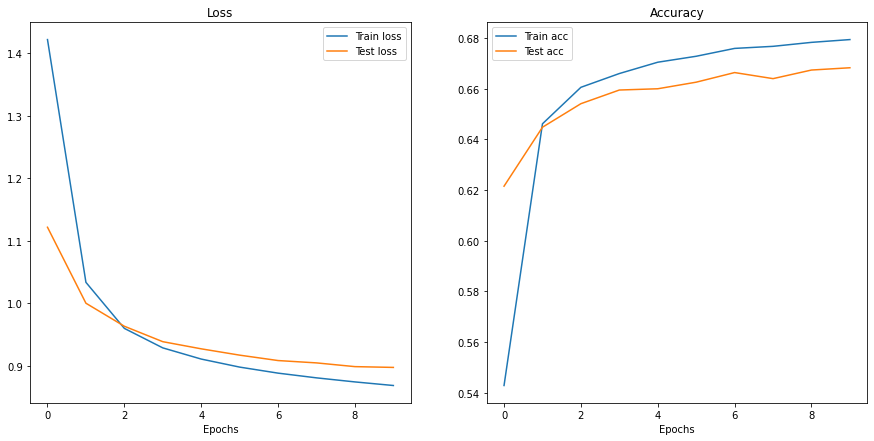

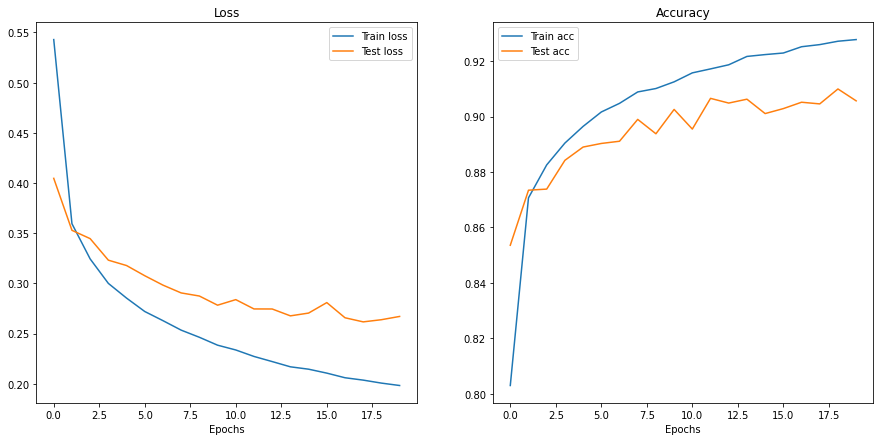

In [37]:
plot_loss_curves(model_1_results)
plot_loss_curves_2(model_2_results)

# 7.Image recognition tests

### 7.1Make prediction on the image lable and compare it with the real one

After analysis, we can see that model 2 performs better, so we use it for recognition tests.

In [39]:
def make_predictions(model : torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model will give raw logits)
      pred_logit = model(sample)

      # Get prediction probability( logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

(-0.5, 27.5, 27.5, -0.5)

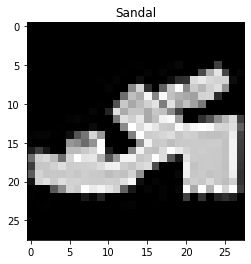

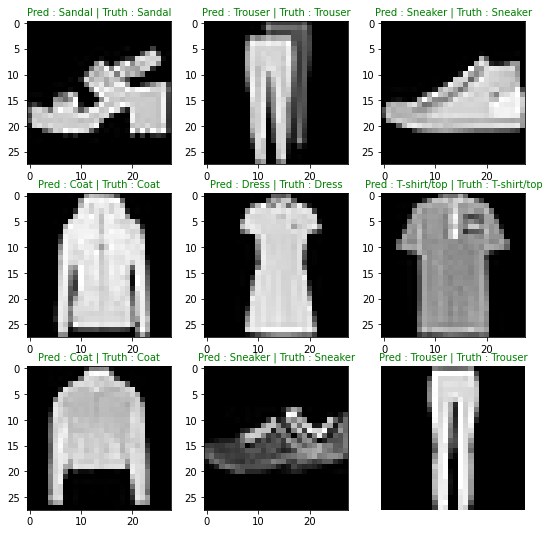

In [40]:
import random
random.seed(42)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

# Make predictions
pred_probs = make_predictions(model = model_2,
                              data=test_samples)

# View first two prediction probabilities 
pred_probs[:2]
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim = 1)


# Plot predictions 
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap = "gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred : {pred_label} | Truth : {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c = "g") # Green text if the prediction is the same
  else :
    plt.title(title_text, fontsize = 10, c = "r") 
plt.axis(False)

### 7.2 Make a confusion matrix for further prediction evaluation

The confusion matrix is an excellent way to visually evaluate a classification model. It provides a comprehensive table showing the overlap between Predicted Label and True Label, allowing us to visualise the true performance of the model.

In [46]:
# Make predictions with trained model
y_preds = []

model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)

    # Do the forward pass
    y_logit = model_2(X)

    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim=1)

    # Put predictions on CPU for evalutation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]
     

Making predictions...: 100%|██████████| 313/313 [00:01<00:00, 285.91it/s]


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [47]:
# See if the required packages are installed and if not, install them ...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version : {mlxtend.__version__} ")
  assert int(mlxtend.__version__.split(".")[1] >= 19), "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version : {mlxtend.__version__} ")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00
mlxtend version : 0.21.0 


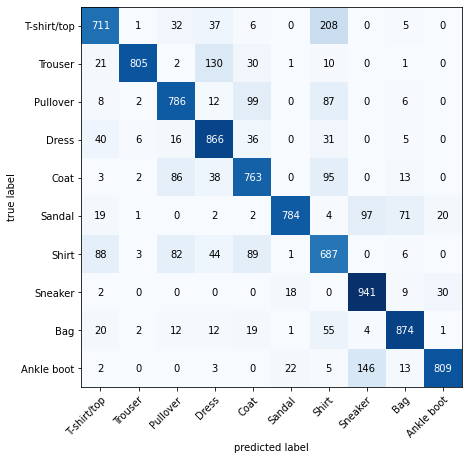

In [58]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass",num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), # Matplotlib likes numpy
                                class_names = class_names,
                                figsize=(10,7))
     

# 8.Load the saved best performing model

After repeated debugging, we have improved the accuracy of model 2 to over 90%. Therefore, we saved it for next time.

In [41]:
print("FashionMNISTModelV2: \n\n", model_2, "\n")
print("The state dict keys: \n\n", model_2.state_dict().keys())

FashionMNISTModelV0: 

 FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
) 

The state dict keys: 

 odict_keys(['conv_block_1.0.weight', 'conv_block_1.0.bias', 'conv_block_1.2.weight', 'conv_block_1.2.bias', 'conv_block_2.0.weight', 'conv_block_2.0.bias', 'conv_block_2.2.weight', 'conv_

In [42]:
torch.save(model_2.state_dict(), 'checkpoint.pth')

In [43]:
state_dict = torch.load("checkpoint.pth")
print(state_dict.keys())

odict_keys(['conv_block_1.0.weight', 'conv_block_1.0.bias', 'conv_block_1.2.weight', 'conv_block_1.2.bias', 'conv_block_2.0.weight', 'conv_block_2.0.bias', 'conv_block_2.2.weight', 'conv_block_2.2.bias', 'classifier_layer.1.weight', 'classifier_layer.1.bias'])


In [45]:
# Load the state dict to the network
model_2.load_state_dict(state_dict)
print(model_2)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)
